# 202308126_katagaitai勉強会 Crypto入門(RSA暗号入門)


## 対象
初めてCrypto問を解く人

## 環境構築
- python3用\
`pip3 install pycryptodome`
- SageMath用\
`apt install sage`\
`sage -pip install pycryptodome`

SageMath:複雑な科学技術計算をサポートするソフトウェア。pythonのように扱える。\
pycryptodome:pythonの暗号系ライブラリ。pythonとsageどちらでも使えるようにしておくと便利。

## jupyter notebookの使い方
notebookの起動：sage -n jupyter\
セルの編集：Enter\
セルの実行：Ctrl＋Enter\
セルの実行と追加：Alt＋Enter\
セルの削除：dd

## フラグの扱い
Crypto問ではフラグをバイト列として与えられ、数値に変換して操作することが多いです。\
まずは1文字(1byte)の変換を見てみましょう。\
pythonではUnicode文字を与えると整数に変換/逆変換する関数として**ord()/chr()**があります。

In [ ]:
hex(ord("a"))

In [ ]:
chr(0x61)

2文字以上の変換を見てみましょう。\
ここではpycryptodomeの**bytes_to_long()/long_to_bytes()**を使います。\
(慣れてる人はint.from_bytes()やint.to_bytes()でも良いです)

In [ ]:
from Crypto.Util.number import long_to_bytes,bytes_to_long

In [ ]:
flag = b'flag{katagaitai}'
bytes_to_long(flag)

In [ ]:
n = 136143999223211945088441554101120100733
long_to_bytes(n)

### 演習1
131061755621485をバイト列に直してください

## 素因数分解の困難性
RSA暗号は2つの大きな素数を掛け合わせた合成数の、素因数分解の困難性に基づきます。\
簡単に言うと、掛け算よりも素因数分解の方がはるかに難しいという数学的な根拠により、
RSA暗号の安全は保たれています。\
さらに数値が大きくなればなるほど困難であるため、その指標としてbit長が用いられます。

- 例）2つの5bit素数の積
    - 5bitの2つの素数の積が713であるとき、その2つの素数を求められるか
    - ↑たった5bitでも難しさは感じてもらえると思います。

pycryptodomeでは**getPrime(bit_length)**で指定したビット数のランダムな素数を生成できます。\
bit数毎の素数の総数が気になる人は素数定理で調べてみてください。\
また、sagemathでは素因数分解を行う関数として**factor(n)**があります。

In [ ]:
factor(713)

In [ ]:
from Crypto.Util.number import getPrime
bit_length = 5
getPrime(bit_length)

### 演習2
次の実験スクリプトのbit_lengthを変えて何bit程度から時間がかかるか試してみてください

In [ ]:
bit_length = 5
p = getPrime(bit_length)
q = getPrime(bit_length)
factor(p*q)

### 参考
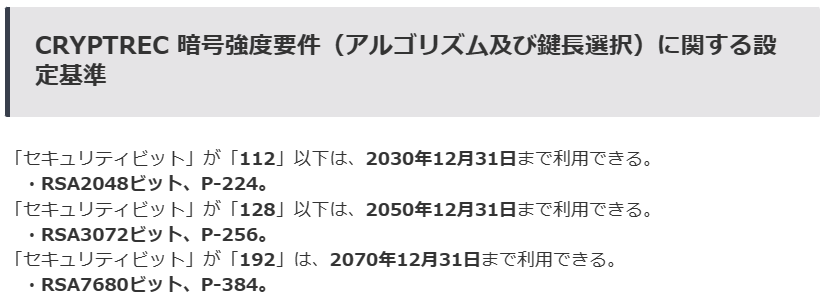

## 鍵生成
では、本題のRSA暗号に入りましょう。\
RSA暗号では公開鍵$(N,e)$と秘密鍵$(d)$を用意します。

### 公開鍵
2つの異なる大きな素数$p,q$に対し、
$$N=p*q$$を計算します。\
$e$は、$\phi(N)$(後述)と互に素な大きすぎず小さすぎない数として$$e=0\text{x}10001(65537)$$ がよく使われます。

In [ ]:
bit_length = 1024
p = getPrime(bit_length)
q = getPrime(bit_length)
m = bytes_to_long(b'flag{katagaitai}')
e = 0x10001
N = p*q
(N,e)

### 秘密鍵
$$d=e^{-1} \mod \phi(N)$$$d$は法$\phi(N)$のもとで、$e$の逆数です。\
$\phi(n)$はオイラー関数と呼ばれるもので、\
$n$と互いに素である$1$以上$n$以下の自然数の個数と定義されます。\
(素数$p$に対して$\phi(p)=p-1$であることは明らか)\
また、m,nが互いに素なとき、$\phi(mn)=\phi(m)\phi(n)$と分解できます。\
RSA暗号の場合、
$$\phi(N)=\phi(p)\phi(q)=(p-1)(q-1)$$と計算されます。
そのため、$p$や$q$を知っていれば、$\phi(N)$が求まり、秘密鍵$d$が計算されます。
$N$だけ知っていても、$N$と互いに素である$1$以上$N$以下の自然数を数え上げるのは大変なので
$d$は求まりません。(素因数分解も困難なためできない)

In [ ]:
phi = (p-1)*(q-1)
d = pow(e,-1,phi)
(d)

## 暗号化
平文を$m$,暗号文を$c$として、暗号文は
$$ c=m^e \mod N$$と計算されます。

これは($m$,$e$,$N$)から$c$を生成するため、公開鍵を知る誰もが計算できます。

In [ ]:
c = pow(m,e,N)
c

## 復号
復号は
$$ m=c^d \mod N$$と計算されます。

これは($c$,$d$,$N$)から$m$を生成するため、秘密鍵を知る者のみが計算できます。

In [ ]:
m = pow(c,d,phi)
long_to_bytes(int(m))

なぜこれで復号できるか、説明しましょう。\
その前にオイラーの定理について紹介します。

### オイラーの定理
任意の自然数$a,N$に対し、
$$a^{\phi(N)} \equiv 1 \mod N$$が成り立つ。\
証明：https://manabitimes.jp/math/667

$m^{\phi(N)} \equiv 1 \mod N$ももちろん成り立ちます。\
mod Nではこれを何度かけても値は変わらないので、
$$c^d \equiv m^{ed} \equiv m^{ed+\phi(N)}\equiv m^{ed+2\phi(N)}\equiv m^{ed+3\phi(N)}\equiv m^{ed \bmod \phi(N)} \pmod N$$
つまり$\phi(N)$は指数部の法とみなせる。\
鍵生成の条件から、
$$ed \equiv1 \bmod \phi(N)$$であるから、
$$c^d \equiv m \mod N$$

---

では実際にCTFの問題を解いてみましょう。

### 演習3 追加パラメータの問題①
どうやらpに乱数をかけた値も出力されているようです。

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long
from Crypto.Random.random import getrandbits

flag = b"flag{katagaitai-ex3}"
m = bytes_to_long(flag)

bit_length = 1024
p = getPrime(bit_length)
q = getPrime(bit_length)
N = p*q
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)
print("rp =", getrandbits(bit_length)*p)

In [ ]:
N = 22675639216467947554613926900267571378015269731369077734668301748186910137272508787006484362363534756088840004311171892202038881851034685552739181978608660136730736273024887798204956172317840992692726710905082617205503905370618639949006048337113660569237842898908104055481689145527154120901182256365499341823730660798183255602327895328078763979627957435369761550948873549725908723067459443937677080409534342635311045927996522280464977055555624709250750945538676667567393603731458207157666473936300404647566573372907483465998258176692239964116955479427129141656730332350209753315815233853783463664667904718453304144309
e = 65537
c = 18624256959460305786304594527439176053424071089656289837696393855863507395974907096398168971130071177060355418727808414789584674846409118377553862680681034417440734003666563244569409162789221972162214723631828819643914284760723876192869877144073192193137987274420170147729311660448206731796545592741396013321732107698039558963846562030995929344335995876085527275850910222917056196466215376475150438584247357573744587366710437556047774724505835196937152130210178312584878279859629280245267402604463188513075125707883794526075268663523513466714719579404332563700751933669479815093009079531639047234330606846544422759193
rp = 27198336051734798371447544187230833721983344301589767548115867638830864796158132099264147471531601230878703890275296156571889314838366623298741747570577928703200405981898243774116223831702460942131383569635801361561265161756684668099136739999256472129354872143479307805972161024238273584055975733763750718847260705750877359375172372148135567530170638973925376605716146346212675453826141188215242991442085951684207528513708119291083680494681131677778975327530137622071487030979509928109184175105790754707055401917945655091551142548701619230869634181402034330107040512696978043555398775735587684105892787602802881780484

In [ ]:
# solver
# ヒント：gcd(a,b)
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 演習4 追加パラメータの問題②
どうやらp+qの値も出力されているようです。

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex4}"
m = bytes_to_long(flag)

bit_length = 1024
p = getPrime(bit_length)
q = getPrime(bit_length)
N = p*q
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)
print("p_plus_q =", p+q)

In [ ]:
N = 13556765838208445796468671151463572941007721522483109571961641108177678157207919255062518130474265493546682474630740599139560541607376944305486579205787574062454796759647285433966057721827818746453605463219117719093772416511085744265174013837799951840909473068492129354423444496811546665438618310371324769131344240644450429250130931841089754455205732257564353068087590332516158269853260753453992813981662843745303784053168406806245124823974051910529967804982104276003488855044775884590635885387731886335505471889609361790348955130191105810830423255264706664245481553357299073353777822882374230920725852615790188599649
e = 65537
c = 7920786415848087326842763753427936405268597102962472581198612669369217404299200349112789577305194992836835110702801189099739916423764990831638940199069327368064062673938631509552825902628470791042984884628106617997234787802930249715530507384349989052310201768074260096685431988724010852872281075848458520104313761248629022780981586339378956005767524307760430106832178546855084364512502096511389744797442549658303031948716030398231234853960671292445827824503933119212622571070443332930750866977970378193063955954146130336129577875992693909878686125031804146918754442865427671936447173765524823554955134131196980164475
p_plus_q = 236871202011754883355716365820484160083170066052842116297650531722366466587256500907296880754770375047537251057697705331974882994673329865739731594637127454660985351777500851946530871480215367707818608126627519647766234092543190391579341270643191248877330091740577243386073033293157200113965085408895719265614

In [ ]:
# solver
# ヒント：KKK, sqrt()
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 演習5 パラメータが悪い問題(e=3)
eが小さいと何がいけないのでしょうか。

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex5}"
m = bytes_to_long(flag)

bit_length = 1024
p = getPrime(bit_length)
q = getPrime(bit_length)
N = p*q
e = 3
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)

In [ ]:
N = 20790814503571187594036267079346881473920873518668001520972164942460762428045601197101327876805229716122889488093525591063046998551671503016490149590634416310331230603652552571669396805076828305998532335856925695402964983253363726124380567842493735896442469570643648217881000385627027743904674838938114264204703302955527556074689019655580992263599470777339652981028911824803959546905440606504732161917622949466222468629081716869527629157934069462826421889533809391473838700013532969280429444938961226724059091922295149969148746107965308360542232215202295212848154347006858135595998792141717173766693396010304869575323
e = 3
c = 199928678441516494174002060088682408634637667346309746680031329170772374978087533195210475665695496318599223629467640891188809307882237350208613

In [ ]:
# solver
# ヒント：n**(a/b)
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

ちなみに、eが大きい(dが小さいとき)は連分数を利用したWiener's Attackが適用できます。

---

### 演習6 パラメータが悪い問題(q=next_prime(p))
pとqが近いと問題はありますか？

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex6}"
m = bytes_to_long(flag)

bit_length = 1024
p = getPrime(bit_length)
q = next_prime(p)
N = p*q
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)

In [ ]:
N = 25455868100462612450372345346907546005989493093662866560766538159696083830834121083663976446806262384498270569530949413204929763654418886137245424996883091287973651257212941330186989518566984801539348302605017112250867114131830796278109249662076378316661082842655372574617890669430165121786201157303327108570030971967962250916171154744383517525996660094148701014788247653209195423687484900719980196919674024325907462854611693094448736537781828391802258484882885522483289397730361767414594717288377489063434206936073390561881454683124223932469053127728161846876553286281501216288690504728920509254967351337066337095517
e = 65537
c = 3890532309507830782544345712384692478607888273630135566623415685247015535724597511827624716631556782403608427261488405898522014691162563852209003354036335066910180546675047092278237213073423973058319989772353744768413963807201701070054211952740775435476548542791596829148852159572803357253394832596588735155754146724053275345964349134965603917982038831480746259941157415136222988473382992039455910670864823635555748299953401546679719377445186193921947366287046955205463080720204120774686862739447392117466260856734252134670350710884299779155539939941906413202754151315572999870123418395475039964831615325229184075006

In [ ]:
# solver
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 演習7 RSAみたいな暗号(pohlig-helman暗号)
素数pだけだと問題はありますか？

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex7}"
m = bytes_to_long(flag)

bit_length = 2048
p = getPrime(bit_length)
N = p
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)

In [ ]:
N = 29729022820324633722664704553717493337169518388179122414721114013006378808176474225746131178080578164978409877042360059293145137707084567956773928485366005259422472044164656019997104703619940422215858014402877702996469798096814011256794364802600200128639040109395844526340362587242453728991721316521041966426275921617044131238715737169174101156906748317499860372954238431443698221126377175858450150516082003924846025391290494185187886104437272922111465480027999133880004133498610480809999742069852269936271416031139007329324491224144061819702766740280717933293330526365648571952135937691084189230934392138164904193063
e = 65537
c = 21531442715153231354880193091148885604059639339381334389595628054402101831613466089069540492570483706439145279888901255052883766556921207534844641436427942361262376402229392108904578378140228119879887750934584587032058695514901356314610427175241468586804503792222137917232448806413417492651238387517031050746881009686378613896506670075280921962984502396889211945909692080282510433807666933612734124348452819741434135280127647929678351738685451390182953798115659689262923246445321721397612042831792527593384997888660600220881855257579316041552316888349156902975262660097317521212807745364862431467559288178928216280162

In [ ]:
# solver
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 演習8 RSAみたいな暗号(Multi-prime RSA)
素数を増やしたらどうでしょう？

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex8}"
m = bytes_to_long(flag)

bit_length = 128
primes = [getPrime(32) for _ in range(64)]
N = prod(primes)
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)

In [ ]:
N = 184681655202826323581439133114426032211213220238405372673410074931217859888263409386139782751668222388919646755228494986461933087553610335684826609436545298735658222878258727597542533763515279327921708330942272709707335507022055140215012486490848168772758817272166403981406575534451088031104935465053933218473099481983245699195151859523858029324419504178081357227700925437255838090384367718202753929608578056965209238890453951212799569247784402619601602867161185221192557610651528220110129145499672049613469225671431995371692965356058812987655545387859576962606927630516416536251608028185944115805436436797199
e = 65537
c = 127313637262654441468107647251719023090100401208788021873188482290280932098015024139853540952733180370482176288289979168865331383788477325360976948226612102754045358716053353937179626195139689059354314424675286560365105317189004762916598676847106054359015980967060391944731504891608197713884577408391920965634133927586003078640118861874730936292567514781579141669139298237671300641445770136314914205284325482896615227180402244526762308852300433069873650504298088456628525857122397759716046469963251900743821635430319440040499069743431454173421224768404367877102671754049256329869250036592147689240343783812163

In [ ]:
# solver
# ヒント：for p,k in factor()
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 演習9 パラメータが悪い問題(q=p)
pとqが同じとき復号できますか？

In [ ]:
from Crypto.Util.number import getPrime
from Crypto.Util.number import bytes_to_long

flag = b"flag{katagaitai-ex9}"
m = bytes_to_long(flag)

bit_length = 1024
p = getPrime(bit_length)
q = p
N = p*q
e = 0x10001
c = pow(m,e,N)

print("N =", N)
print("e =", e)
print("c =", c)

In [ ]:
N = 22393104769196980383971821301111169491898506600381424562425526610720227040783935675118901590810046184141732512649986479129989961343017106745449683390916114912742120217683080644878477868709619722680836261474324434543248368762605988399839382365595451855441863810892820225199521042948085567932129533251164520612120340303104910173418901703825283190586495857554474703618609959678852843784869110475773095450248836024181427769474752809883251658963115690630091372247783223053420372697154731859272610546496867909775037237017188397980605755421527409433100370750094242044748142218605679608716473535384125910563288373812525581921
e = 65537
c = 4932820020315726812193715031475546663055579381957412987474303097651491623214060505555977389845244456433638471822522238967327442488838904438194577501858602706767332719757081489028192865475711808702577052184988127674500002316953525540712706931570080847044980365747193477343694867534413434287913572937268989752219493168873877033387674594908605217942249940604767296246708720381633756928650039003262861059794360996574156355955806217162826765335900407808815034076169572849103537789279264038806062995006553095360902992690129547651149374457140000059453475823013649099881769011186738700978808395152512489727307341278993793815

In [ ]:
# solver
# ヒント：オイラーのφ関数の定義に注意
from Crypto.Util.number import long_to_bytes

long_to_bytes(int(m))

---

### 補足①(数学知識)
今回はRSAに関するCTF問に慣れてもらうためできるだけ数学的なことを省いたのですが、Crypto問を解くうえで必要な知識を少し補足しておきます。
- 群環体：各値がどの世界で定義されたものなのか意識し、どのような演算ができるか確認する必要があります。
- 最大公約数(GCD)：今回は組み込まれたgcdを使いました。gcdの計算ではユークリッドの互除法が使われています。
- 拡張ユークリッドの互除法：逆元の計算などに使われます。
- 素数判定：CTFではほぼ見かけませんが、素数判定の裏側にミラーラビンテストという手法が存在します。
- 中国人剰余定理(CRT)：RSAでは復号の高速化に用いられますがCTFでもよく使います。

### 補足②(Padding)
RSA暗合は決定論的であるといえます。これは、入力と出力が１対１に対応するということです。\
つまり、盗聴者は復号ができなくても同じメッセージを送っていることを確認できてしまいます。\
そこで、RSAにはいくつかパディング方式が存在しています。\
パディング中に乱数を含むため同じ平文に対しても異なる暗号文を得ることができます。
- PKCS#1 v1.5
- OAEP
- PSS

https://qiita.com/kj1/items/aebbb73a034f36d73e40

### 補足③(RSAの使われ方)
RSA暗号はAES暗号などの共通鍵暗号の鍵配送に使われることが過去にはあった(KEM-DEM)のですが、\
現在鍵配送として使われることはほぼありません。\
というのも、鍵配送では前方秘匿性という性質が求められます。
これは過去の通信セッションの鍵が漏洩しても、他のセッションのセキュリティが侵害されることがないというものです。\
これを満たす、DHE,ECDHEがイマドキの鍵配送です。

ただしRSAが全く使われなくなったわけではなく、\
RSA-OAEPによる暗号化\
RSA-PSS署名\
RSASSA-PKCS1-v1.5\
として活躍しています。

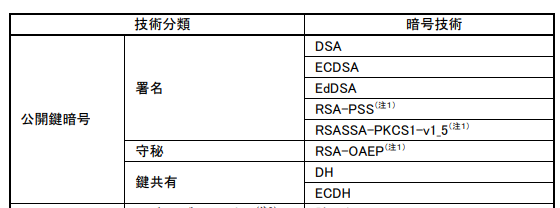

TLS1.3でも上記に準じたRSAの使われ方をしています。\
https://qiita.com/s_machida/items/0f6ef0466503c0f00839